In [2]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import tqdm
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import load_ML100K
from dataset import CustomDataset
from ml100k_pyg_loader import ML100k
from model import Discriminator, Encoder
from utils import get_activation, get_criterion, get_optimizer, get_roc_auc
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch_geometric.transforms as T
from torch_geometric.nn import MetaPath2Vec

dataset = ML100k('../data/ml-100k')
hg = dataset[0]
hg = T.ToUndirected()(hg)

Using existing file ml-100k.zip


In [3]:
hg.edge_index_dict

{('user',
  'rates',
  'movie'): tensor([[ 195,  185,   21,  ...,  275,   12,   11],
         [ 241,  301,  376,  ..., 1089,  224,  202]]),
 ('movie',
  'rev_rates',
  'user'): tensor([[ 241,  301,  376,  ..., 1089,  224,  202],
         [ 195,  185,   21,  ...,  275,   12,   11]])}

In [4]:
metapatorch = [
    ('user', 'rates', 'movie'),
    ('movie', 'rev_rates', 'user'),
]

In [5]:
metapath2vec = MetaPath2Vec(hg.edge_index_dict, embedding_dim=64,
                     metapath=metapatorch, walk_length=50, context_size=2,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

loader = metapath2vec.loader(batch_size=128, shuffle=True, num_workers=6)
optimizer = torch.optim.SparseAdam(list(metapath2vec.parameters()), lr=0.01)
epochs = 50
metapath2vec.train()
for epoch in range(0, epochs):
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = metapath2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        print('\r',f'Epoch: {epoch+1} of {epochs}, Step: {i + 1:.3f}/{len(loader)}, 'f'Loss: {loss:.3f}', end=' ')

 Epoch: 50 of 50, Step: 8.000/8, Loss: 0.491 

In [6]:
embedding_dict = {}
for node_type in metapath2vec.num_nodes_dict:
    # get embedding of node witorch specific type
    embedding_dict[node_type] = metapath2vec(node_type).detach().cpu()
    print(node_type, embedding_dict[node_type].shape)

user torch.Size([943, 64])
movie torch.Size([1682, 64])


/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.72      0.86      0.78       133
         1.0       0.39      0.21      0.28        56

    accuracy                           0.67       189
   macro avg       0.55      0.54      0.53       189
weighted avg       0.62      0.67      0.63       189



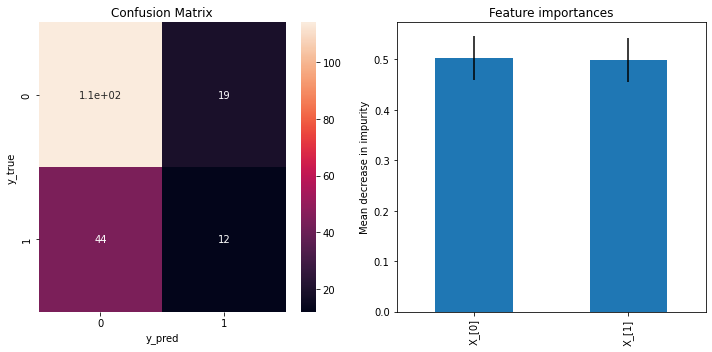

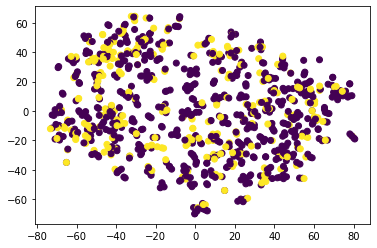

In [7]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2, init='random', perplexity=3).fit_transform(embedding_dict['user'])
# X=embedding_dict['user']
y_true = hg['user'].gender.float()
# importing necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# splitting X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y_true,test_size=.2)

# # training a ML classifier

feature_names = [f"X_{[i]}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
# clf = DecisionTreeClassifier()
y_pred = forest.predict(X_test)

# creating a figure for plotting
fig = plt.figure(figsize=(10,5))
ax1= fig.add_subplot(121)

# creating a confusion matrix
cm =  confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True).plot()
ax1.set_title("Confusion Matrix")
ax1.set_ylabel("y_true")
ax1.set_xlabel("y_pred")

# creating feature importances
ax2 = fig.add_subplot(122)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.plot.bar(yerr=std, ax=ax2)
ax2.set_title("Feature importances")
ax2.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

print(classification_report(y_test, y_pred))

fig = plt.figure(figsize=(6,4))
# Embedding plot
if X.shape[1] > 2:
    print('3d')
    ax_emb = fig.add_subplot(projection='3d')
    ax_emb.scatter(X[:,0],X[:,1],X[:,2], c=y_true)
else:
    ax_emb = fig.add_subplot()# create axes
    ax_emb.scatter(X[:,0],X[:,1], c=y_true)
    
plt.show()

In [8]:
from torch_geometric.utils import index_to_mask
from sklearn.manifold import TSNE
X = TSNE(n_components=3, init='random', perplexity=3).fit_transform(embedding_dict['user'])
X = torch.tensor(X)
y_true = hg['user'].gender.float()
entities=np.array(range(X.shape[0]))
num_ents = len(entities)
cutoff = int(np.round(entities.shape[0]*.9))
train_set = CustomDataset(entities[:cutoff])
test_set = CustomDataset(entities[cutoff:])
discriminator=Discriminator(hidden_dim = X.shape[0], out_dim=OUT_DIM, activation=get_activation(ACTIVATION), num_layers=2, dropout=0.3, relu = 0.2)
train_loader = DataLoader(train_set, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
loss_fn = get_criterion(CRITERION)
opt = get_optimizer(OPTIMIZER,discriminator.parameters())

/usr/local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


NameError: name 'OUT_DIM' is not defined

In [ ]:
def test_discriminator(test_loader,discriminator, y_true, num_ents):
    probs_list, labels_list = [], []
    for p_batch in test_loader:
        p_batch_var = Variable(p_batch).to(device)
        mask=index_to_mask(p_batch_var, num_ents)
        p_batch_emb=X[mask].detach()
        y_hat = discriminator(p_batch_emb)
        y = Variable(torch.FloatTensor(y_true[mask].detach())).to(device)
        probs_list.append(y_hat)
        labels_list.append(y)
    Y = torch.cat(labels_list,0)
    Y_hat = torch.cat(probs_list,0)
    loss = loss_fn(Y_hat,Y)
    auc = get_roc_auc(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy())
    return loss, auc

In [ ]:
discriminator.eval()
dataloader=tqdm.tqdm(range(1, EPOCHS+1))
train_loss_vals, test_loss_vals = [], []
train_auc_vals, test_auc_vals = [], []
for epoch in dataloader:
    probs_list, labels_list = [], []
    for p_batch in train_loader:
        p_batch_var = Variable(p_batch).to(device)
        mask=index_to_mask(p_batch_var, num_ents)
        p_batch_emb=X[mask].detach()
        y_hat = discriminator(p_batch_emb)
        y = Variable(torch.FloatTensor(y_true[mask].detach())).to(device)
        probs_list.append(y_hat)
        labels_list.append(y)
        loss = loss_fn(y_hat,y)
        opt.zero_grad()
        loss.backward()
        opt.step()

    Y = torch.cat(labels_list,0)
    Y_hat = torch.cat(probs_list,0)
    train_auc = get_roc_auc(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy())
    train_loss = loss_fn(Y_hat, Y)
    test_loss, test_auc = test_discriminator(test_loader, discriminator, y_true, num_ents)
    train_loss_vals.append(train_loss.item())
    test_loss_vals.append(test_loss.item())
    train_auc_vals.append(train_auc.item())
    test_auc_vals.append(test_auc.item())
    dataloader.set_description(
        f'Train Loss: {train_loss:.2f}, \
        Train AUC: {train_auc:.2f}, Test Loss: {test_loss:.2f}, \
        Test AUC: {test_auc:.2f}'
    )


In [ ]:
from plot import PrEFairApp
app=PrEFairApp()
user_embs = embedding_dict['user'].detach()
y_true = hg['user'].gender.float()
# data = TSNE(n_components=3, init='random', perplexity=3).fit_transform(user_embs)
train_metrics = {
        'loss_vals':train_loss_vals,
        'auc_vals':train_auc_vals
        }
test_metrics = {
        'loss_vals':test_loss_vals,
        'auc_vals':test_auc_vals
        }
# app.init_fig(train_metrics, test_metrics, data, y_true, projection = '3d')
app.init_fig(train_metrics, test_metrics, data, y_true)
app.mainloop()